In [26]:
%matplotlib inline

In [27]:
from pyspark.ml.classification import LogisticRegression,LogisticRegressionModel
from pyspark.ml.feature import StandardScaler,StandardScalerModel
import matplotlib.pyplot as plt


In [91]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix

In [2]:
training = spark.read.format("libsvm").load("/Users/qingpeng/Local/GeneLearn/training.vect")
testing = spark.read.format("libsvm").option("numFeatures", "19421").load("/Users/qingpeng/Local/GeneLearn/testing.vect")

## StandardScaler with iteration of 100 and 500

In [3]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [4]:
scalerModel = scaler.fit(training)

In [5]:
scaledTraining = scalerModel.transform(training)

In [6]:
scaledTesting = scalerModel.transform(testing)

In [40]:
lr_scaler = LogisticRegression(featuresCol="scaledFeatures",maxIter=500)

In [41]:
lrModel_scaler = lr_scaler.fit(scaledTraining)

In [9]:
evaluation_scaler = lrModel_scaler.evaluate(scaledTesting)

In [124]:
evaluation_scaler.areaUnderROC

0.9461628200000001

In [42]:
evaluation_scaler_500Iter = lrModel_scaler.evaluate(scaledTesting)

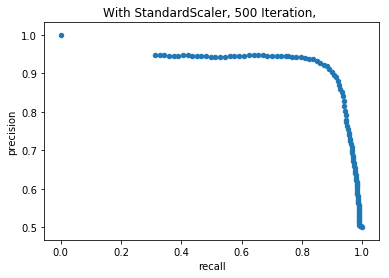

In [88]:
evaluation_scaler_500Iter.pr.toPandas().plot.scatter(x='recall', y='precision', title='With StandardScaler, 500 Iteration, ')

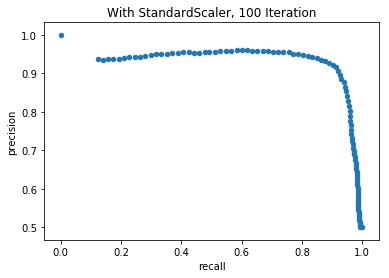

In [89]:
pr.toPandas().plot.scatter(x='recall', y='precision', title='With StandardScaler, 100 Iteration')

## Without StandardScaler

In [33]:
lr_default = LogisticRegression()

In [34]:
lrModel_default = lr_default.fit(training)

In [35]:
evaluation_default = lrModel_default.evaluate(testing)

In [36]:
evaluation_default.areaUnderROC

0.9461046200000001

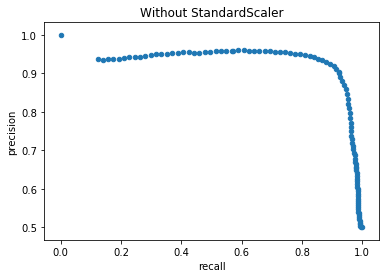

In [90]:
evaluation_default.pr.toPandas().plot.scatter(x='recall', y='precision', title='Without StandardScaler')

## Comparison

In [92]:
def evaluate_model(evaluation):
    
    label_list = []
    probability_list = []
    prediction_list = []
    for i in evaluation.predictions.collect():
        label_list.append(i.label)
        probability_list.append(i.probability[1])
        prediction_list.append(i.prediction)
        
    au_PRC = average_precision_score(label_list,probability_list)
    au_ROC = evaluation.areaUnderROC
    
    matrix = confusion_matrix(label_list, prediction_list)
    
    precision_list = []
    recall_list = []
    for i in evaluation.pr.collect():
        precision_list.append(i.precision)
        recall_list.append(i.recall)
    return au_PRC, precision_list, recall_list, au_ROC, matrix

In [93]:
au_PRC_500, precision_list_500, recall_list_500, au_ROC_500, matrix_500 = evaluate_model(evaluation_scaler_500Iter)

In [94]:
au_PRC_100, precision_list_100, recall_list_100, au_ROC_100, matrix_100 = evaluate_model(evaluation_scaler)

In [95]:
au_PRC_default, precision_list_default, recall_list_default, au_ROC_default, matrix_default = evaluate_model(evaluation_default)

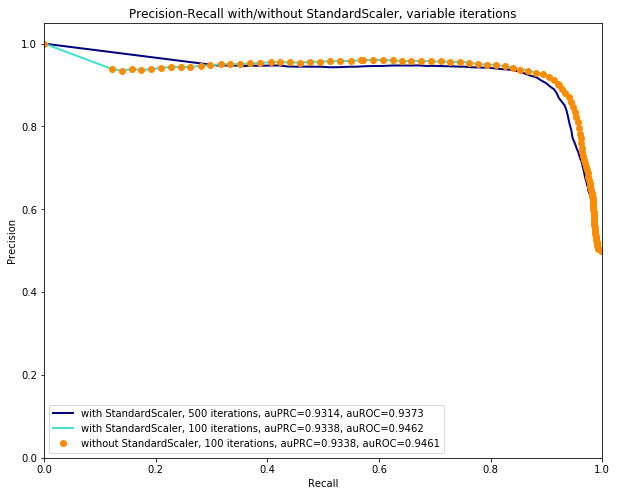

In [111]:

lw = 2
plt.figure(figsize=(10, 8), dpi=80)

# Plot Precision-Recall curve
plt.clf()
plt.plot(recall_list_500, precision_list_500, lw=lw, color='navy',
         label='with StandardScaler, 500 iterations, auPRC={0:0.4f}, auROC={1:0.4f}'.format(au_PRC_500,au_ROC_500))


plt.plot(recall_list_100, precision_list_100, lw=lw, color='turquoise',
         label='with StandardScaler, 100 iterations, auPRC={0:0.4f}, auROC={1:0.4f}'.format(au_PRC_100,au_ROC_100))
plt.plot(recall_list_default, precision_list_default,'ro', lw=lw, color='darkorange',
         label='without StandardScaler, 100 iterations, auPRC={0:0.4f}, auROC={1:0.4f}'.format(au_PRC_default,au_ROC_default))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall with/without StandardScaler, variable iterations')
plt.legend(loc="lower left")
plt.show()

### Observations

1. Using standardScaler does not increase the performance obviously. But it does not hurt either. So generally we will apply such scaler.
2. Using more iterations does not increase the performance. We will keep using 100 iterations.
3. auROC and auPRC highly correate with each other, for this data sets, with balanced classes. For CrossValidation below, we will use auROC as the metric. It is easier/faster to get auROC thanks to the new pyspark.ml.classification.BinaryLogisticRegressionSummary API. but auPRC is not available directly from that API

## Finding optimal regularization parameters and C values

the grid of Cs values (that are set by default to be ten values in a logarithmic scale between 1e-4 and 1e4)

elasticNetParam from 0->1.0, step by 0.1

In [115]:
import numpy as np

In [125]:
elasticNetParam_list = np.arange(0.0,1.0,0.1)

In [126]:
regParam_list = [1*(10**-4),1*(10**-3),1*(10**-2),1*(10**-1),1*(10**0),1*(10**1),1*(10**2),1*(10**3),1*(10**4)]

In [119]:
regParam_list

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

In [121]:
def test_parameters(elasticNetParam,regParam):
    lr = LogisticRegression(featuresCol="scaledFeatures",regParam=regParam, elasticNetParam=elasticNetParam)
    lrModel = lr.fit(scaledTraining)
    evaluation = lrModel.evaluate(scaledTesting)
    return evaluation.areaUnderROC

In [122]:
auROC = test_parameters(0.0,0.0)

In [123]:
auROC

0.9461341599999998

In [127]:
auROC_list_elastic = []
for elasticNetParam in elasticNetParam_list:
    auROC_list_elastic.append(test_parameters(elasticNetParam,0.0))



In [128]:
auROC_list_elastic

[0.9461573000000001,
 0.94616486,
 0.9460893800000001,
 0.9460968600000002,
 0.94612794,
 0.94612086,
 0.9461474000000001,
 0.94611946,
 0.9461638199999998,
 0.94614632]

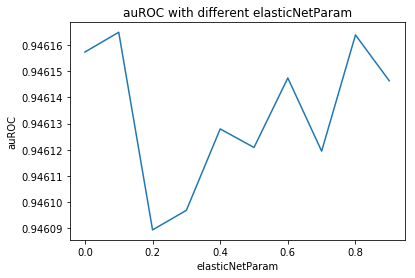

In [134]:
plt.plot(elasticNetParam_list,auROC_list_elastic)
plt.xlabel('elasticNetParam')
plt.ylabel('auROC')
plt.title('auROC with different elasticNetParam')



### Observations

No big difference with different elasticNetParam, L1 or L2